In [1]:
import sys, os
sys.path.insert(0, os.path.abspath(".."))

# Use the street network to redistribute points

Here we use the TIGER/Lines data to for a graph of the street network
- The library code automates loading the data, and can also intelligently discard edges which look "wrong" (have no name, or a name which suggests that they are a railroad).
- We form a Voroni diagram by using the mid point of each edge in the graph.
- However, we then compute the "segments" of the graph.  A segment is a path where each interior node in the path has degree two.  I.e. something which corresponds to the notion of a street between intersections.
- We merge the voroni cells for each segment.

This works pretty well.  Some problems are:
- A small number of cases where we have e.g. parallel roads leading to thin, disconnected, cells
- Somewhat dependent on the edges in the original graph-- our placement of points is not uniform.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import geopandas as gpd
import numpy as np
import tilemapbase
import shapely.geometry
import descartes
import lzma

import opencrimedata.chicago
import opencrimedata.tiger_lines
import opencrimedata.voroni
import opencrimedata.geometry
import opencrimedata.replace

import open_cp.geometry
open_cp.geometry.configure_gdal()
import open_cp.logger
open_cp.logger.log_to_true_stdout("opencrimedata")
import pyproj
proj = pyproj.Proj({"init":"epsg:2790"})

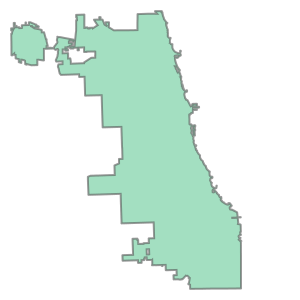

In [3]:
datadir = os.path.join("..", "..", "..", "..", "Data")
#datadir = os.path.join("/media", "disk", "Data")
g = gpd.GeoDataFrame.from_file(os.path.join(datadir, "Chicago_Areas.geojson"))
g.crs = {'init': 'epsg:4326'}
g = g.to_crs({"init":"epsg:2790"}).geometry
chicago = g.unary_union.buffer(15)
chicago

## Load the street network data

Using TIGER/Lines

In [4]:
tigerdir = os.path.join("..", "..", "..", "..", "Data", "TIGER Data")
#tigerdir = os.path.join("/media", "disk", "TIGER Data")
tl = opencrimedata.tiger_lines.TigerLines(os.path.join(tigerdir, "tl_2016_17031_roads"),
                        os.path.join(tigerdir, "tl_2016_17031_edges"), proj)

In [5]:
graph, reduced_edge_lookup = tl.make_reduced_graph()

## Form voroni cells



In [6]:
segments = list(open_cp.network.segment_graph(graph))

In [7]:
voroni = opencrimedata.voroni.VoroniGraphSegments(graph, segments)

## Form the redistributor

In [8]:
redist = voroni.to_redistributor(chicago)

In [12]:
credist = opencrimedata.geometry.CachingRedistributor(redist.polygons)

# Load old data and redistribute

In [13]:
def gen():
    with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as f:
        yield from opencrimedata.chicago.load_only_with_point(f)

next(gen())

Row(id='5189091', crime_type='OFFENSE INVOLVING CHILDREN', crime_subtype='CHILD ABUSE', location='RESIDENCE', address='108XX S AVENUE G', datetime=datetime.datetime(2006, 10, 12, 10, 58), point=(-87.531655723, 41.698387427))

In [16]:
class AssignNew(opencrimedata.replace.AssignNew):
    def adjust(self, row):
        pt = credist.redistribute_within_radius(*proj(*row.point), 100)
        if pt is None:
            return None
        return opencrimedata.chicago.row_with_new_position(row, *proj(*pt, inverse=True))

In [17]:
assign = AssignNew(gen(), seed=1234)
with lzma.open(os.path.join(datadir, "chicago_redist_street_network.csv.xz"), "wt", newline="") as f:
    opencrimedata.chicago.write(f, assign)

Hashes:
- in: `dc1026949999aaccbf6333db953e59decc39906f21908fdda54285ef7dac6e9c`
- out: `51e9564fe4049522b7d281c9ce4f7e58b037d3e1f0985a9338a9eba65caaaf63`
- (6323451, 108)

In [19]:
assign.input_hash

'dc1026949999aaccbf6333db953e59decc39906f21908fdda54285ef7dac6e9c'

In [20]:
assign.output_hash

'51e9564fe4049522b7d281c9ce4f7e58b037d3e1f0985a9338a9eba65caaaf63'

In [21]:
assign.input_size, assign.failed_to_reassign_count

(6323451, 108)

In [22]:
def gen_new():
    with lzma.open(os.path.join(datadir, "chicago_redist_street_network.csv.xz"), "rt") as f:
        yield from opencrimedata.chicago.load_only_with_point(f)

next(gen()), next(gen_new())

(Row(id='5189091', crime_type='OFFENSE INVOLVING CHILDREN', crime_subtype='CHILD ABUSE', location='RESIDENCE', address='108XX S AVENUE G', datetime=datetime.datetime(2006, 10, 12, 10, 58), point=(-87.531655723, 41.698387427)),
 Row(id='5189091', crime_type='OFFENSE INVOLVING CHILDREN', crime_subtype='CHILD ABUSE', location='RESIDENCE', address='108XX S AVENUE G', datetime=datetime.datetime(2006, 10, 12, 10, 58), point=(-87.53132445093954, 41.69779186169136)))

## Load back in and plot example

In [4]:
with lzma.open(os.path.join(datadir, "chicago_redist_street_network.csv.xz"), "rt") as f:
    pts = np.asarray([row.point for row in opencrimedata.chicago.load_only_with_point(f)])

In [5]:
wm_pts = [tilemapbase.project(x,y) for x,y in zip(*pts.T)]
wm_pts = np.asarray(wm_pts)
wm_pts.shape

(6323343, 2)

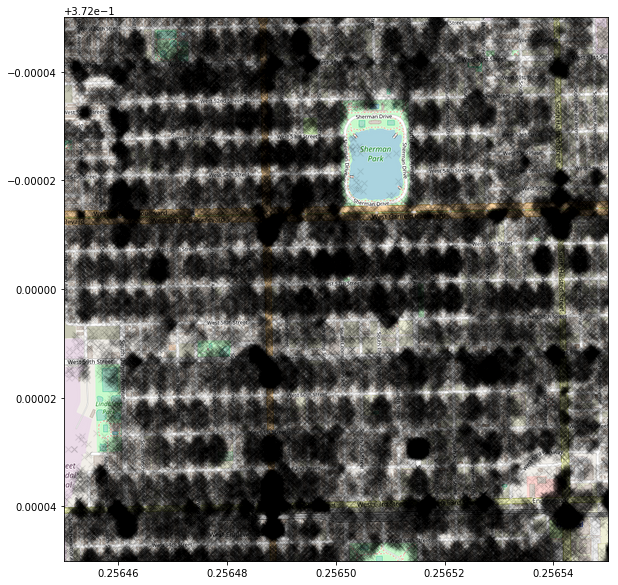

In [6]:
x, y = 0.2565, 0.372
ex = tilemapbase.Extent.from_centre(x, y, xsize=0.0001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

fig, ax = plt.subplots(figsize=(10,10))
plotter.plot(ax)
ax.scatter(*wm_pts.T, marker="x", color="black", linewidth=1, alpha=0.1)

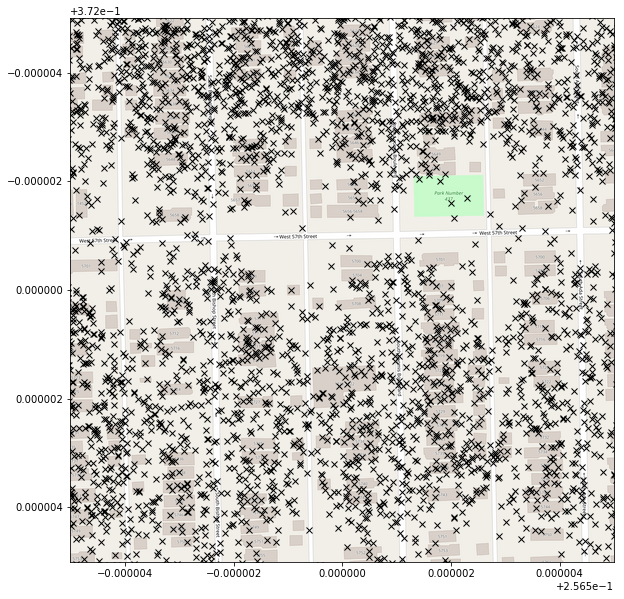

In [7]:
x, y = 0.2565, 0.372
ex = tilemapbase.Extent.from_centre(x, y, xsize=0.00001)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

fig, ax = plt.subplots(figsize=(10,10))
plotter.plot(ax)
ax.scatter(*wm_pts.T, marker="x", color="black", linewidth=1, alpha=1)

## Reload and more plots

This time a plot from old to new location.

In [4]:
with lzma.open(os.path.join(datadir, "chicago_redist_street_network.csv.xz"), "rt") as f:
    pts_by_id = {row.id : row.point for row in opencrimedata.chicago.load_only_with_point(f)}
    
with lzma.open(os.path.join(datadir, "chicago_all.csv.xz"), "rt") as f:
    for row in opencrimedata.chicago.load_only_with_point(f):
        if row.id not in pts_by_id:
            continue
        new_pt = pts_by_id[row.id]
        pts_by_id[row.id] = (row.point, new_pt)

In [5]:
keys = list(pts_by_id.keys())
for i in keys:
    old_pt, new_pt = pts_by_id[i]
    assert len(old_pt) == 2
    assert len(new_pt) == 2

In [6]:
old_wm_pts = [tilemapbase.project(*pts_by_id[i][0]) for i in keys]
new_wm_pts = [tilemapbase.project(*pts_by_id[i][1]) for i in keys]

In [7]:
old_wm_pts = np.asarray(old_wm_pts)
new_wm_pts = np.asarray(new_wm_pts)

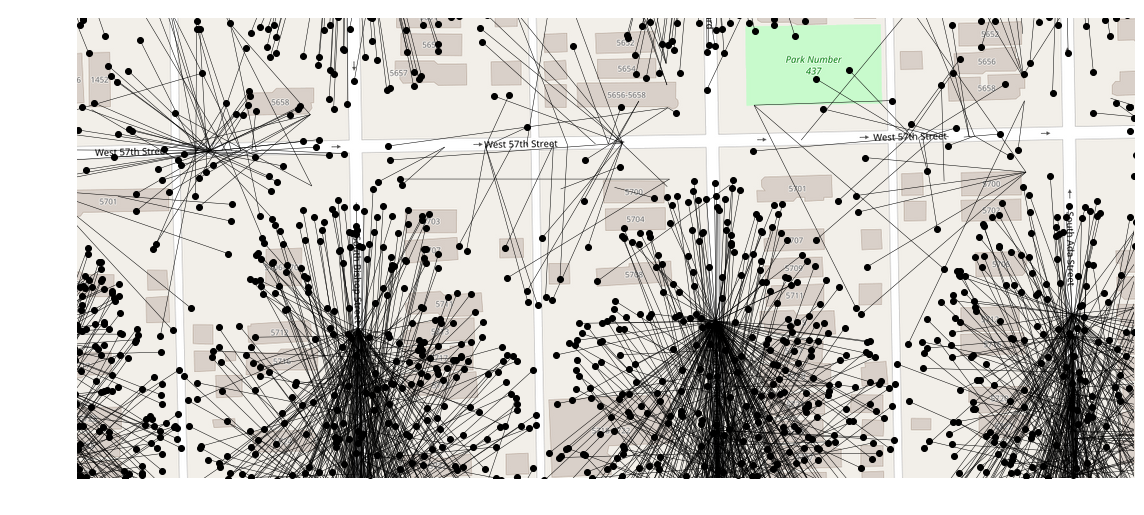

In [8]:
x, y = 0.2565, 0.372
ex = tilemapbase.Extent.from_centre(x, y, xsize=0.00001, aspect=2.3)
plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

fig, ax = plt.subplots(figsize=(16,8))
plotter.plot(ax)
#ax.scatter(*old_wm_pts.T, marker="x", color="black", linewidth=1, alpha=1)
ax.scatter(*new_wm_pts.T, marker="o", color="black", linewidth=1, alpha=1)

lines = []
for x,y,xx,yy in zip(*old_wm_pts.T, *new_wm_pts.T):
    lines.append(((x,y), (xx,yy)))
ax.add_collection(matplotlib.collections.LineCollection(lines, color="black", linewidth=0.5))
ax.set_axis_off()
fig.tight_layout()

In [9]:
fig.savefig("chicago_redist_network.png", dpi=100)

# Plot polygons

Run the notebook again until we form `redist` and then skip here.

In [16]:
def project_polygon(p):
    if p.geometryType() == "Polygon":
        poly = []
        for x, y in zip(*proj(*np.asarray(p.exterior).T, inverse=True)):
            poly.append(tilemapbase.project(x, y))
        return shapely.geometry.Polygon(poly)
    else:
        return shapely.geometry.MultiPolygon([project_polygon(pp) for pp in p])
    
def draw(lon, lat, polys, xsize=0.0001, ax=None):
    ex = tilemapbase.Extent.from_centre_lonlat(lon, lat, xsize)
    plotter = tilemapbase.Plotter(ex, tilemapbase.tiles.OSM, width=800)

    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    else:
        fig = None
    plotter.plot(ax, alpha=0.6)

    pp = [descartes.PolygonPatch(project_polygon(p)) for p in polys if not p.is_empty]
    #pp = matplotlib.collections.PatchCollection(pp, color="red", alpha=0.3)
    pp = matplotlib.collections.PatchCollection(pp, facecolor="none", edgecolor="black")
    ax.add_collection(pp)
    
    return fig

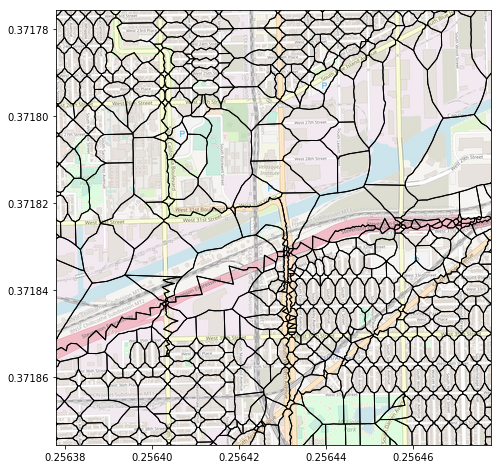

In [10]:
fig = draw(-87.686, 41.837, redist.polygons)

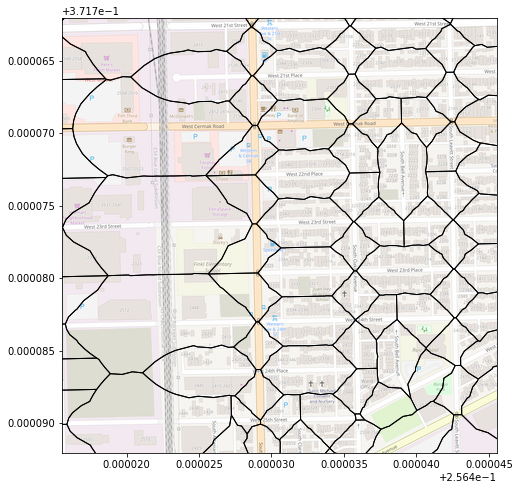

In [12]:
fig = draw(-87.685, 41.85, redist.polygons, 0.00003)

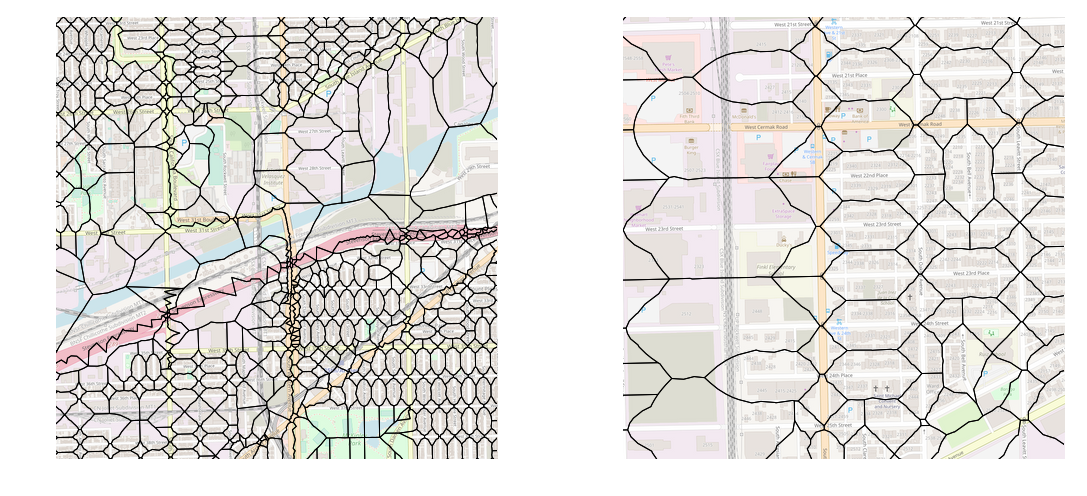

In [17]:
fig, axes = plt.subplots(ncols=2, figsize=(16,7))

draw(-87.686, 41.837, redist.polygons, ax=axes[0])
draw(-87.685, 41.85, redist.polygons, 0.00003, ax=axes[1])
for ax in axes:
    ax.set_axis_off()
fig.tight_layout()

In [18]:
fig.savefig("chiago_voroni_street_network_polys.png", dpi=150)